ORGANIZACIJA:
evo linka od prezentacije:
https://fb.watch/4y-LKdA7iT/

UPUTE:
pokrenuti zakomentiranu skriptu ispod i uploadat si pkl file na google disk.

In [ ]:
# import pickle

# start_time = time.time()
# tcurrent = start_time
# np.random.seed(33)

# filename = 'LUMEN_DS.csv'
# df = pd.read_csv(filename, encoding="UTF-16LE", sep='|', quotechar='"', low_memory=False)

# to_drop_too_much_missing = ['Price last modified date in the ERP',
#                             'Sales Channel - Grouping',
#                             'Material cost of part',
#                             'Labor cost of part',
#                             'Overhead cost of part']

# df.drop(to_drop_too_much_missing, inplace=True, axis=1)

# to_drop_unimportant = [
#     'Sales Channel - Internal',
#     'Sales Channel - External']

# df.drop(to_drop_unimportant, inplace=True, axis=1)

# with open('LUMEN2.pkl', 'wb') as f:
#     pickle.dump(df, f)

In [ ]:
!pip install sweetviz

In [ ]:
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
import os
import time
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import sweetviz as sv
import xgboost as xgb
import pickle
from sklearn import metrics
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/LUMEN2.pkl"
with open(data_path, 'rb') as f:
    df = pickle.load(f)
print(df.shape)

(1294962, 26)


Outlieri i dalje nisu gotovi, automatska detekcija pomocu IsolationForest ili LocalOutlierFactor mi nije davala dobre rezultate.

Zasad sam samo s desne strane krivulje rucno odbacio vrijednosti vece od q3+1.5iqr. 

Kako upariti 

In [ ]:
df = df[~df['Invoiced price'].isnull()]

# df = df[~df['GM%'].isnull()]
# df = df[df['GM%'] >= -1]  # ???
# df = df[df['GM%'] <= 1]  # ???
#df.dropna(inplace=True)

#0 je po meni legalna vrijednost za invoiced quantity, ali ne i za ordered
df = df[df['Invoiced qty (shipped)'] >= 0]
df = df[df['Invoiced qty (shipped)'] < 1000000]
df = df[df['Ordered qty'] > 0]
df = df[df['Ordered qty'] < 1000000]
df = df[df['Invoiced price'] > 0]
df = df[df['Invoiced price'] < 100000]
df = df[df['Cost of part'] >= 0]
df = df[df['Cost of part'] < 75000]

df = df[~df['# of unique products on a quote'].isnull()]
df = df[df['# of unique products on a quote'] < 374]
df = df[df['# of unique products on a quote'] > 0]

#simple drop
df = df[~df['Product group'].isnull()]
df = df[~df['Manufacturing Location Code'].isnull()]
df = df[~df['Make vs Buy'].isnull()]
df = df[~df['Customer industry'].isnull()]

#ovo nije dobro, maknuo sam ih jer ih je malo. Jel se ovdje moze koristiti SMOTE?
# df = df[df['Product family']!='PC010']
# df = df[df['Product family']!='PC001']
# df = df[df['Product family']!='PC016']

df['Invoiced qty (shipped)'].astype(int)
df['Ordered qty'].astype(int)
df['# of unique products on a quote'].astype(int)

df['Invoiced qty (shipped)'] = np.log10(df['Invoiced qty (shipped)'] + 1)
df['Ordered qty'] = np.log10(df['Ordered qty'] + 1)
df['Cost of part'] = np.log10(df['Cost of part'] + 1)
df['Invoiced price'] = np.log10(df['Invoiced price'] + 1)
df['# of unique products on a quote'] = np.log10(df['# of unique products on a quote'] + 1)

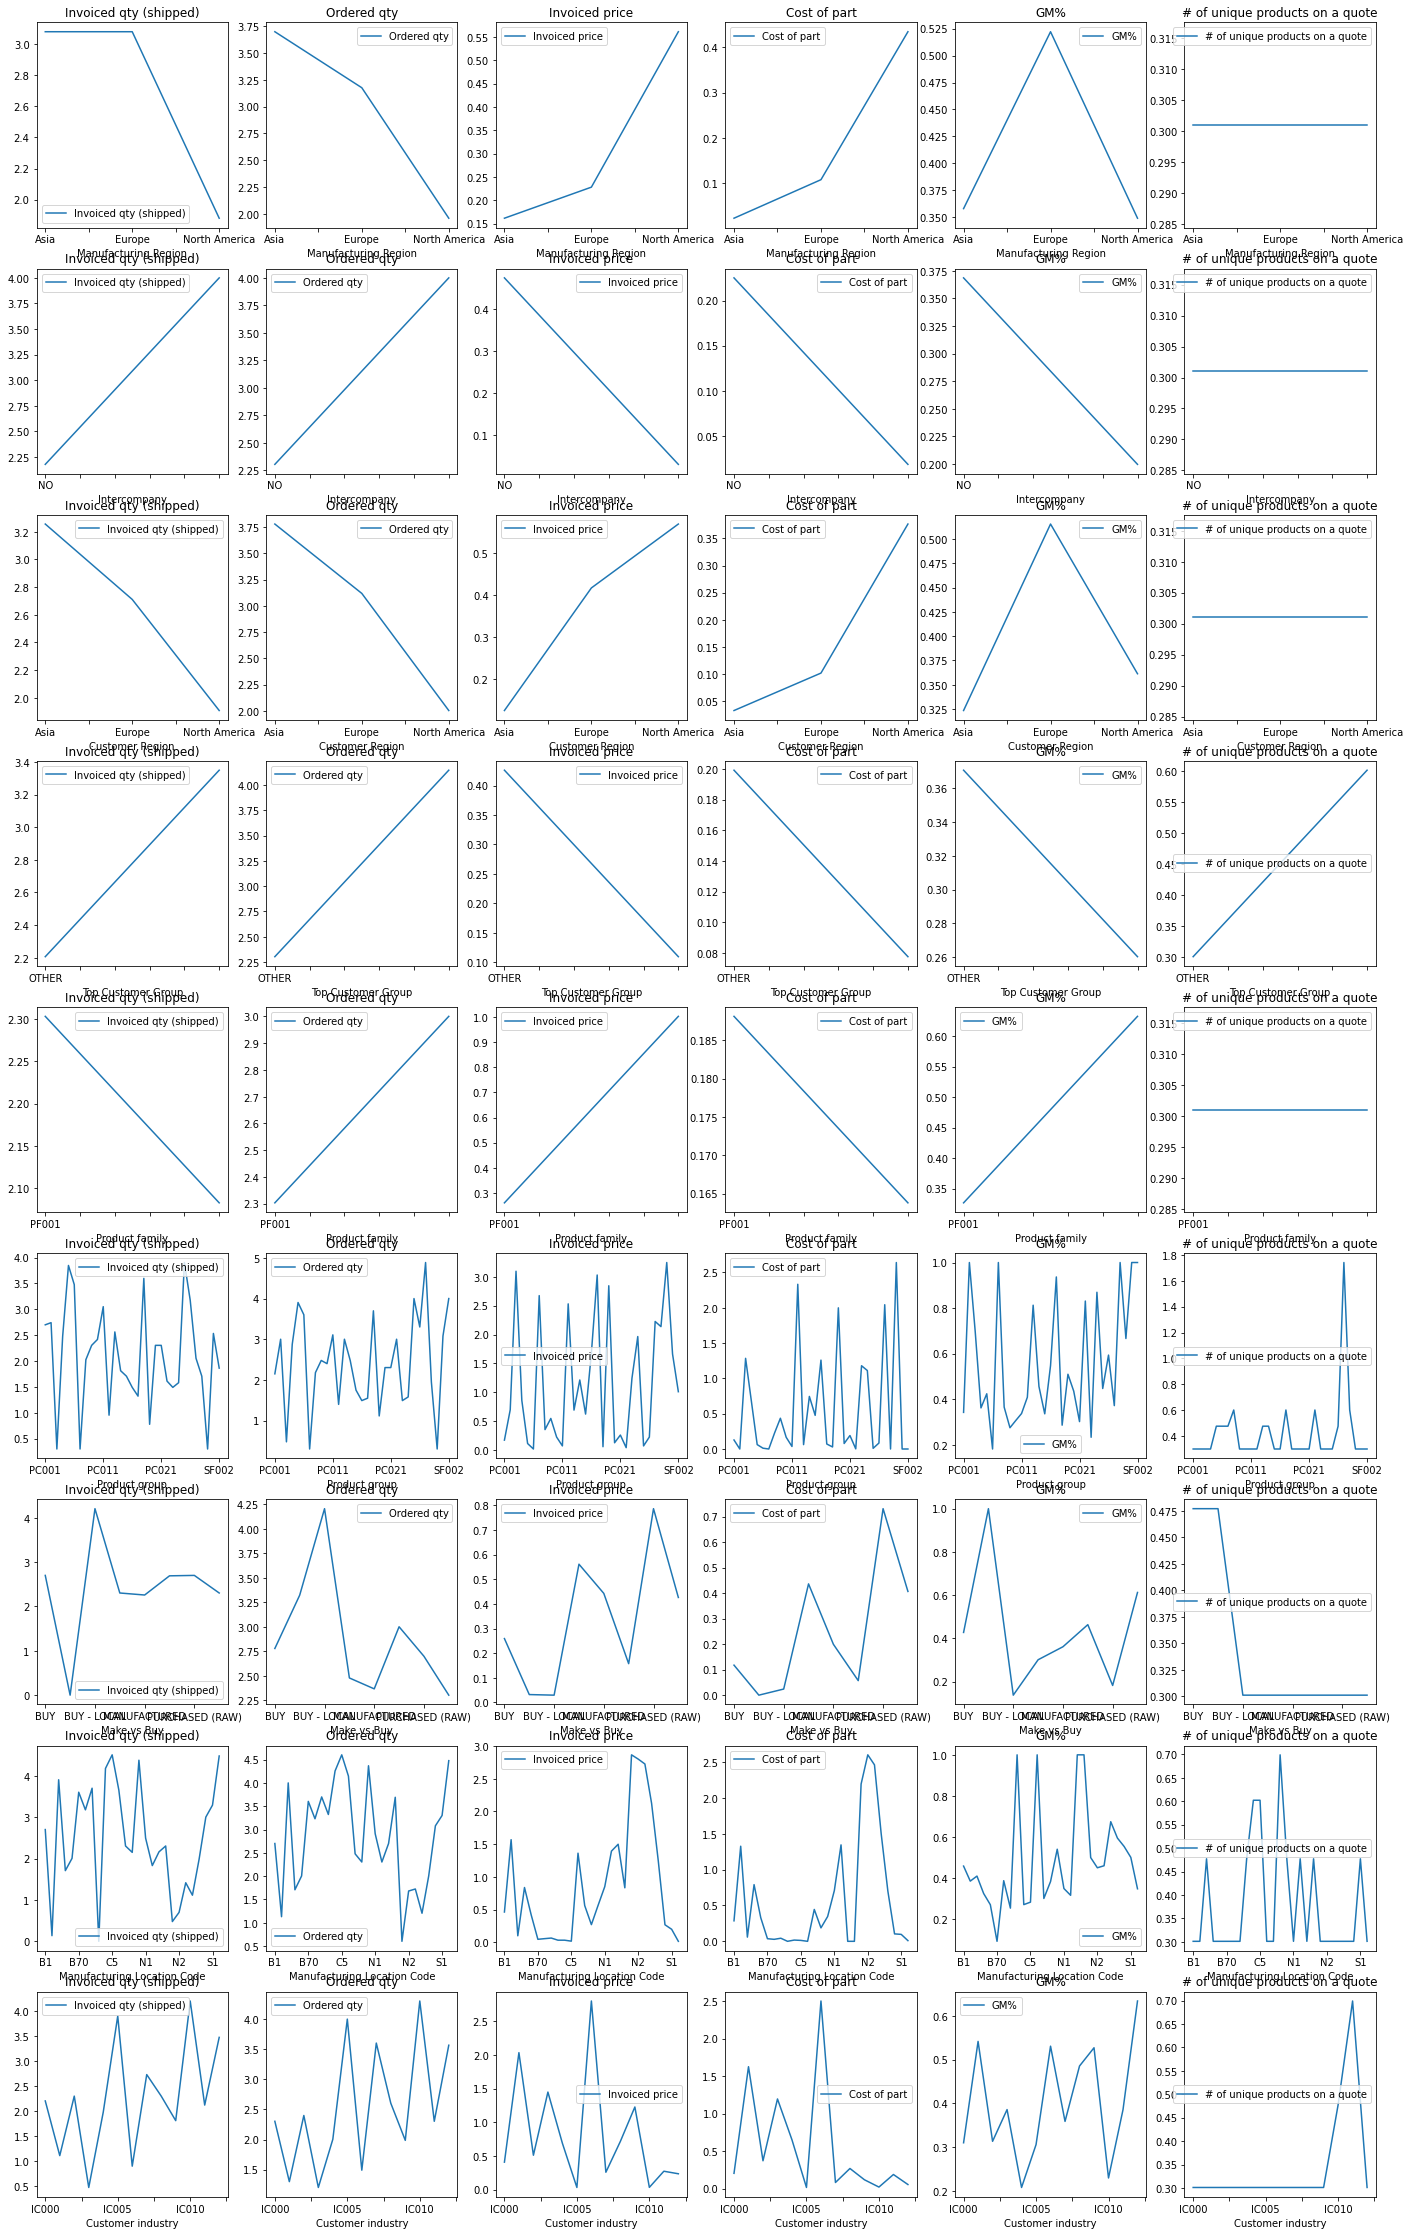

In [ ]:
plt.figure(figsize=(24,40))
eda_columns=['Manufacturing Region','Intercompany','Customer Region','Top Customer Group','Product family','Product group','Make vs Buy','Manufacturing Location Code','Customer industry']
numeric_cols=['Invoiced qty (shipped)','Ordered qty','Invoiced price','Cost of part','GM%', '# of unique products on a quote']

for j in range(len(eda_columns)):
  df1=df.groupby(by=eda_columns[j])
  for i in range(len(numeric_cols)):
    plt.subplot(len(eda_columns),len(numeric_cols),j*len(numeric_cols)+i+1)
    plt.title(numeric_cols[i])
    df1[numeric_cols[i]].median().plot(legend=True)

plt.show()

<Figure size 1728x2160 with 0 Axes>

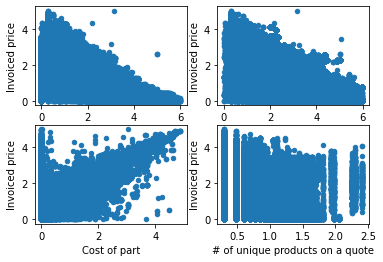

In [ ]:
plt.figure(figsize=(24,30))
fig, axes = plt.subplots(nrows=2, ncols=2)

numeric_cols2=['Invoiced qty (shipped)','Ordered qty','Cost of part','# of unique products on a quote']
for i in range(len(numeric_cols2)):
  var=numeric_cols2[i]
  data = pd.concat([df['Invoiced price'], df[var]], axis=1)
  data.plot.scatter(ax=axes[i//2,i%2],x=var, y='Invoiced price');

plt.show()

In [ ]:
to_drop_highly_correlated = [#'Invoiced price',
                             'Invoiced price (TX)']

df.drop(to_drop_highly_correlated, inplace=True, axis=1)

In [ ]:
to_drop_output = [#'Invoiced price',
                  'GM%']

df.drop(to_drop_output, inplace=True, axis=1)

Na datumima jos uvijek radim, glavna ideja mi je za feature uzeti broj dana izmedju 'Customer First Invoice Date',
                 'Born on date',
                 'Order Date' 
i  Invoice Date-a

In [ ]:
# import pandas as pd
# import seaborn as sns
# import numpy as np
# import pickle
# import sweetviz as sv

# data_path = "LUMEN2.pkl"
# with open(data_path, 'rb') as f:
#     df = pickle.load(f)

# to_drop_dates = ['Customer First Invoice Date',
#                  'Born on date',
#                  'Invoice Date',
#                  'Order Date']
# df=df[to_drop_dates]
# df1=df[to_drop_dates].copy()
# print(df[df['Born on date']=='2001-12-06'])
# print('original naovi')
# print(df[df['Customer First Invoice Date'].isna()])
# print(df[df['Born on date'].isna()])
# print(df[df['Invoice Date'].isna()])
# print(df[df['Order Date'].isna()])

# today = pd.to_datetime("today")


# df1['Customer First Invoice Date']=pd.to_datetime(df1['Customer First Invoice Date'], errors='coerce',format='%Y-%m-%d %H:%M:%S')
# df1['Born on date']=pd.to_datetime(df1['Born on date'], errors='coerce',format='%Y-%m-%d')
# df1['Invoice Date']=pd.to_datetime(df1['Invoice Date'], errors='coerce',format='%Y-%m-%d')
# df1['Order Date']=pd.to_datetime(df1['Order Date'], errors='coerce',format='%Y-%m-%d')

# print(9999)
# print(df1[df1['Customer First Invoice Date']>today])
# print(df1[df1['Born on date']>today])
# print(df1[df1['Invoice Date']>today])
# print(df1[df1['Order Date']>today])

# print('natovi')
# print(df1[~np.isfinite(df1['Customer First Invoice Date'])])
# print(df1[~np.isfinite(df1['Born on date'])])
# print(df1[~np.isfinite(df1['Invoice Date'])])
# print(df1[~np.isfinite(df1['Order Date'])])

# print('izvedeni natovi')
# df1['inv_firinv_diff']= df1['Invoice Date'] - df1['Customer First Invoice Date']
# print(df1[~np.isfinite(df1['inv_firinv_diff'])])
# df1['inv_born_diff']= df1['Invoice Date'] - df1['Born on date']
# print(df1[~np.isfinite(df1['inv_born_diff'])])
# df1['inv_ord_diff']= df1['Invoice Date'] - df1['Order Date']
# print(df1[~np.isfinite(df1['inv_ord_diff'])])

# df1.dropna(inplace=True)

# df1['inv_firinv_diff']=df1['inv_firinv_diff'].dt.days.astype(int)
# df1['inv_born_diff']=df1['inv_born_diff'].dt.days.astype(int)
# df1['inv_ord_diff']=df1['inv_ord_diff'].dt.days.astype(int)

# df1.drop(to_drop_dates, inplace=True, axis=1)

# # print(df1.head(20))

In [ ]:
to_drop_dates = ['Customer First Invoice Date',
                 'Born on date',
                 'Invoice Date',
                 'Order Date']

df.drop(to_drop_dates, inplace=True, axis=1)

Prvih 6 featura u listi su svojevrsni id-evi, koristit ce kod bilo kakvog grupiranja i punjenja praznih vrijednosti(na tom radim).

Zadnja 4 su kategoricki koje jos nisam uklopio. Postoji hashing trick, ali sumnjam obzirom na mali broj klasa da je to najbolje rjesenje.

In [ ]:
to_drop_need_fe = [
                   'Invoice Line #',#ima date u sebi?
                   'Order Line #',
                   'Invoice #',
                   'Order #',
                   '# of unique products on a quote'#droppam svejedno jer je losa korelacija
                   ]

df.drop(to_drop_need_fe, inplace=True, axis=1)

In [ ]:
# train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
#                                                       "Family" : 0, "Normal" : 0, "Partial" : 1})

Ideje za neke nove feature

iz worda:

Grupirati po transakcijama

Stvari koje se narucuju u grupama - prihvatljiviji manji GM%

Relationship between order, invoice and deal

Usporedba razlicitih salesamana

Clustering customers

Kako se mjenja cjena itema kroz vrijeme


In [ ]:
#df['itemqty0'] = df.groupby('Order #')['Item Code'].transform('nunique')
df['itemqty12'] = df.groupby(['CustomerID', 'Customer industry', 'Manufacturing Region', 'Product group'])[
    'Item Code'].transform('nunique')
df['total_part_cost']=df['Invoiced qty (shipped)']*df['Cost of part']
df['deal_size'] = df.groupby(['CustomerID', 'Customer industry', 'Manufacturing Region', 'Product group'])[
    'total_part_cost'].transform('sum')
df['deal_qty'] = df.groupby(['CustomerID', 'Customer industry', 'Manufacturing Region', 'Product group'])[
    'Invoiced qty (shipped)'].transform('sum')

#df = df[df['itemqty12'] < 500]

df['itemqty12'] = np.log10(df['itemqty12'] + 1)
df['deal_size'] = np.log10(df['deal_size'] + 1)
df['deal_qty'] = np.log10(df['deal_qty'] + 1)

In [ ]:
to_drop_need_fe2 = ['CustomerID',
                   'Item Code',
                  #  'Product group',
                  #  'Customer industry'
                  #   'Manufacturing Location Code',
                  #  'Make vs Buy',
                   ]

df.drop(to_drop_need_fe2, inplace=True, axis=1)

In [ ]:
# dummies = ['Manufacturing Region',
#            'Intercompany',
#            'Customer Region',
#            'Product family',
#            'Top Customer Group',
            #'Product group',
            #'Manufacturing Location Code'
            # 'Make vs Buy',
            # 'Customer industry'


# df.drop(dummies, inplace=True, axis=1)
df = pd.get_dummies(df, drop_first=True)

Mozda ce trebat dvoklik na mapu Files gore lijevo da se refresha, downloadajte html i otvorite s browserom.

In [ ]:
# sv_report = sv.analyze(df, target_feat='Invoiced price')
# sv_report.show_html('SV_report_lumen19.html')

Jel vrijedi tvrdnja:
Sto je dobro za linearnu regresiju dobro je za sve modele?
Tj. moze li nam ovo posluzit za evaluaciju u feature engineeringu prije nego uopce krenemo razmisljati o modelu?

In [ ]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(df.drop('Invoiced price', axis=1), df['Invoiced price'], test_size=0.25)

# regr = DecisionTreeRegressor(max_depth=5)
# regr.fit(x_train, y_train)
# print(regr.score(x_valid, y_valid))

regr2 = LinearRegression()
regr2.fit(x_train, y_train)
y_trpred=regr2.predict(x_train)
y_pred=regr2.predict(x_valid)

mse_tr=metrics.mean_squared_error(y_trpred,y_train)
rmse_tr=np.sqrt(mse_tr)
r2_tr=regr2.score(x_train, y_train)
#print(mse_tr)
print(rmse_tr)
print(r2_tr)
#print(r2_tr-rmse_tr)
print()
mse=metrics.mean_squared_error(y_pred,y_valid)
rmse=np.sqrt(mse)
r2=regr2.score(x_valid, y_valid)
#print(mse)
print(rmse)
print(r2)
#print(r2-rmse)

# 0.3726835151106834
# 0.808589594406683

# 0.37093042883107574
# 0.8106338319300423

# 0.33185182763802074
# 0.8399602338321936

# 0.32953367974510733
# 0.8416536212557204

# 0.3229132547126829
# 0.848089292879383

# 0.3227261763839638
# 0.8492521424555781

#all cats no bucket, onehot
0.29235276513317354
0.8758120089412094

0.2925961341055447
0.8749992404497785


0.29235276513317354
0.8758120089412094

0.2925961341055447
0.8749992404497785
